## Berkson's Paradox

Berkson's paradox deals with the observation that there can be a negative correlation between two positive traits in a population. That is, members of a population that have the one trait seem to lack the other trait. This apparent negative correlation can arise when we ignore members of the population which have neither of these traits. When we ignore such members, it might happen that, of the remaining population, the majority have only one or the other of the two traits. This leads to the apparent negative correlation. 

The simulation example given in the book about newsworthiness and trustworthiness of scientific articles can exemplify this paradox should we consider only those articles whose _combined_ newsworthiness and trustworthiness is high. This can happen as in this sub-population of scientific articles, the majority are likely to have one or the other of these two characteristics but not both.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

### Code 6.1

In [2]:
from scipy.stats import norm


N = 200
p = 0.1

nw = norm.rvs(loc=0, scale=1, size=N)
tw = norm.rvs(loc=0, scale=1, size=N)

score = nw + tw
# select the top 90% of the combined score
q = np.quantile(score, 1 - p)

selected = np.where(score >= q, True, False)

np.corrcoef(nw[selected], tw[selected])

array([[ 1.        , -0.75838389],
       [-0.75838389,  1.        ]])

# Multicollinearity

## Multicollinear Legs

### Code 6.2

In [3]:
from scipy.stats import uniform


N = 100

height = norm.rvs(loc=10, scale=2, size=N)
leg_prop = uniform.rvs(loc=0.4, scale=0.1, size=N)

leg_left = height * leg_prop + norm.rvs(loc=0.0, scale=0.02, size=N)
leg_right = height * leg_prop + norm.rvs(loc=0.0, scale=0.02, size=N)

df = pd.DataFrame({'height': height, 'leg_left': leg_left, 'leg_right': leg_right})
df.head()

,height,leg_left,leg_right
0,7.181975,3.175249,3.131016
1,14.258628,6.701894,6.723827
2,9.282675,3.757850,3.774733
3,8.824388,3.706454,3.668122
4,10.557050,4.258135,4.265500


### Code 6.3

In [4]:
with pm.Model() as m_6_1:
    a = pm.Normal('a', mu=10, sigma=100)
    b_l = pm.Normal('b_l', mu=2, sigma=10)
    b_r = pm.Normal('b_r', mu=2, sigma=10)
    
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a + b_l * df['leg_left'] + b_r * df['leg_right'])
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'])
    
    trace_6_1 = pm.sample(2000, init='advi', tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 18100
Interrupted at 18,099 [9%]: Average Loss = 6,506.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_r, b_l, a]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 108 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [5]:
az.summary(trace_6_1, hdi_prob=0.89, var_names=['a', 'b_l', 'b_r', 'sigma'])

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.287,0.357,0.718,1.861,0.005,0.004,4375.0,4249.0,4382.0,4284.0,1.00
b_l,-2.217,2.541,-6.063,1.965,0.105,0.084,591.0,453.0,594.0,555.0,1.01
b_r,4.155,2.539,0.010,8.034,0.104,0.080,592.0,504.0,596.0,538.0,1.01
sigma,0.671,0.049,0.594,0.750,0.001,0.000,5118.0,5118.0,4957.0,2919.0,1.00


### Code 6.5

In [6]:
df_6_1 = pm.trace_to_dataframe(trace_6_1)
df_6_1.head()

,a,b_l,b_r,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,...,mu__90,mu__91,mu__92,mu__93,mu__94,mu__95,mu__96,mu__97,mu__98,mu__99
0,1.346147,-6.851448,8.780677,0.660259,7.083530,14.468220,8.744143,8.160162,9.625733,12.507135,...,9.886972,11.518032,9.230125,10.873051,12.376745,11.148902,11.466929,10.623322,10.151884,12.473420
1,1.605759,-6.832442,8.715298,0.653599,7.198789,14.415613,8.828389,8.250402,9.687403,12.500440,...,9.947431,11.529488,9.306175,10.904334,12.371363,11.177018,11.485563,10.660836,10.201555,12.466199
2,1.807257,-6.758521,8.588120,0.772091,7.236811,14.257404,8.827612,8.259383,9.661192,12.395397,...,9.918018,11.447302,9.294738,10.843371,12.268480,11.111180,11.409492,10.606948,10.161334,12.361029
3,2.024130,-6.939360,8.748466,0.704699,7.381519,14.340447,8.970179,8.394151,9.791981,12.497136,...,10.054856,11.549760,9.438210,10.960204,12.368436,11.231114,11.522848,10.726834,10.287664,12.460801
4,1.286462,-7.141527,9.079369,0.708225,7.037980,14.472807,8.721866,8.120950,9.604922,12.500782,...,9.876356,11.497247,9.216225,10.857087,12.366567,11.140339,11.456512,10.606651,10.134578,12.464536


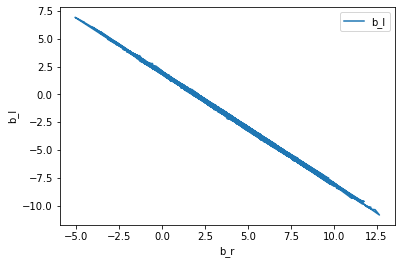

In [7]:
df_6_1[['b_l', 'b_r']].plot('b_r', 'b_l')
plt.ylabel('b_l')
plt.show()

### Code 6.6

<AxesSubplot:ylabel='Density'>

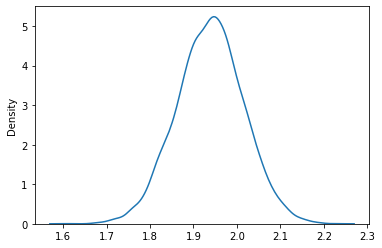

In [8]:
sns.kdeplot(df_6_1['b_l'] + df_6_1['b_r'])

In [9]:
(df_6_1['b_l'] + df_6_1['b_r']).describe([0.055, 0.945]).reset_index()

,index,0
0,count,8000.000000
1,mean,1.938115
2,std,0.077168
3,min,1.607815
4,5.5%,1.813508
5,50%,1.939400
6,94.5%,2.060527
7,max,2.231210


In [10]:
df_6_1[['b_l', 'b_r']].cov()

,b_l,b_r
b_l,6.454271,-6.446789
b_r,-6.446789,6.445262


In [11]:
# Var(b_l + b_r) = Var(b_l) + Var(b_r) + 2 * Cov(b_l, b_r)
cov = df_6_1[['b_l', 'b_r']].cov()

theoretical_var = cov.loc['b_l', 'b_l'] + cov.loc['b_r', 'b_r'] + 2 * cov.loc['b_l', 'b_r']
actual_var = (df_6_1['b_l'] + df_6_1['b_r']).var()

theoretical_var, actual_var

(0.005954827152541142, 0.00595482715253754)

### Code 6.7

In [12]:
with pm.Model() as m_6_2:
    a = pm.Normal('a', mu=10, sigma=100)
    b_l = pm.Normal('b_l', mu=2, sigma=10)

    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a + b_l * df['leg_left'])
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'])
    
    trace_6_2 = pm.sample(2000, init='advi', tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 13400
Interrupted at 13,399 [6%]: Average Loss = 2,438.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_l, a]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 14 seconds.


In [13]:
az.summary(trace_6_2, hdi_prob=0.89, var_names=['a', 'b_l', 'sigma'])

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.296,0.367,0.705,1.866,0.008,0.006,2020.0,2020.0,2024.0,2455.0,1.0
b_l,1.938,0.080,1.819,2.071,0.002,0.001,2088.0,2088.0,2091.0,2549.0,1.0
sigma,0.680,0.050,0.602,0.757,0.001,0.001,3606.0,3497.0,3747.0,3188.0,1.0


## Multicollinear Milk

### Code 6.8

In [14]:
MILK_DATA = '../../data/milk.csv'
df_milk = pd.read_csv(MILK_DATA)

df_milk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


In [15]:
from scipy.stats import zscore

df_milk['K'] = zscore(df_milk['kcal.per.g'])
df_milk['F'] = zscore(df_milk['perc.fat'])
df_milk['L'] = zscore(df_milk['perc.lactose'])

### Code 6.9

In [16]:
with pm.Model() as m_6_3:
    a = pm.Normal('a', mu=0.0, sigma=0.2)
    b_f = pm.Normal('b_f', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a + b_f * df_milk['F'])
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df_milk['K'])
    
    trace_6_3 = pm.sample(2000, init='advi', tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 12900
Interrupted at 12,899 [6%]: Average Loss = 45.969
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_f, a]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 9 seconds.


In [17]:
with pm.Model() as m_6_4:
    a = pm.Normal('a', mu=0.0, sigma=0.2)
    b_l = pm.Normal('b_l', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a + b_l * df_milk['L'])
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df_milk['K'])
    
    trace_6_4 = pm.sample(2000, init='advi', tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 13700
Interrupted at 13,699 [6%]: Average Loss = 42.021
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_l, a]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 11 seconds.


In [18]:
summary_6_3 = az.summary(trace_6_3, hdi_prob=0.89, var_names=['a', 'b_f', 'sigma'])
summary_6_4 = az.summary(trace_6_4, hdi_prob=0.89, var_names=['a', 'b_l', 'sigma'])

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [19]:
summary_6_3

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.085,-0.138,0.130,0.001,0.001,9627.0,3683.0,9632.0,5680.0,1.0
b_f,0.856,0.089,0.715,0.997,0.001,0.001,9705.0,9705.0,9803.0,5678.0,1.0
sigma,0.495,0.070,0.382,0.596,0.001,0.001,6720.0,6720.0,6489.0,4232.0,1.0


In [20]:
summary_6_4

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.074,-0.116,0.117,0.001,0.001,9287.0,3640.0,9333.0,5782.0,1.0
b_l,-0.899,0.079,-1.024,-0.775,0.001,0.001,9932.0,9897.0,9959.0,5674.0,1.0
sigma,0.419,0.061,0.326,0.512,0.001,0.001,6003.0,6003.0,5867.0,4494.0,1.0


In [21]:
df_6_3 = pm.trace_to_dataframe(trace_6_3)
df_6_4 = pm.trace_to_dataframe(trace_6_4)

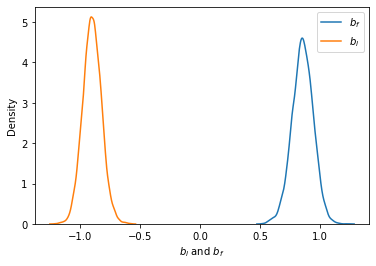

In [22]:
_, ax = plt.subplots(1, 1)
sns.kdeplot(df_6_3['b_f'], ax=ax, label=r'$b_f$')
sns.kdeplot(df_6_4['b_l'], ax=ax, label=r'$b_l$')

plt.xlabel(r'$b_l$ and $b_f$')
plt.legend()
plt.show()

### Code 6.10

In [23]:
with pm.Model() as m_6_5:
    a = pm.Normal('a', mu=0.0, sigma=0.2)
    b_l = pm.Normal('b_l', mu=0.0, sigma=0.5)
    b_f = pm.Normal('b_f', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a + b_l * df_milk['L'] + b_f * df_milk['F'])
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df_milk['K'])
    
    trace_6_5 = pm.sample(2000, init='advi', tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 12100
Interrupted at 12,099 [6%]: Average Loss = 47.919
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_f, b_l, a]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 11 seconds.


In [24]:
az.summary(trace_6_5, var_names=['a', 'b_l', 'b_f', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.072,-0.114,0.116,0.001,0.001,6563.0,3646.0,6596.0,5559.0,1.0
b_l,-0.664,0.201,-0.987,-0.351,0.004,0.003,2225.0,2225.0,2235.0,2480.0,1.0
b_f,0.255,0.201,-0.048,0.589,0.004,0.003,2232.0,2109.0,2238.0,2755.0,1.0
sigma,0.421,0.061,0.325,0.511,0.001,0.001,4546.0,4508.0,4496.0,3718.0,1.0


In [25]:
df_6_5 = pm.trace_to_dataframe(trace_6_5)
df_6_5.head()

,a,b_l,b_f,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,...,mu__19,mu__20,mu__21,mu__22,mu__23,mu__24,mu__25,mu__26,mu__27,mu__28
0,0.128193,-0.748256,0.093154,0.427801,-0.982686,-0.739582,-1.056639,-1.206825,-0.112129,-0.259616,...,1.069554,-1.178727,-0.047898,-0.491673,-0.130765,-0.292126,0.157977,-0.906783,-0.070362,0.776018
1,0.059708,-0.770185,0.226621,0.406274,-1.245682,-0.970588,-1.344992,-1.492129,-0.250149,-0.458396,...,1.217894,-1.453430,-0.116704,-0.648826,-0.171547,-0.436353,0.058699,-1.124902,-0.118127,0.880179
2,-0.015653,-0.935435,0.076738,0.383184,-1.355219,-1.058856,-1.440627,-1.630646,-0.297106,-0.464342,...,1.103702,-1.598491,-0.237264,-0.769161,-0.350113,-0.521847,0.031203,-1.273288,-0.271940,0.747545
3,-0.015653,-0.935435,0.076738,0.383184,-1.355219,-1.058856,-1.440627,-1.630646,-0.297106,-0.464342,...,1.103702,-1.598491,-0.237264,-0.769161,-0.350113,-0.521847,0.031203,-1.273288,-0.271940,0.747545
4,-0.162167,-0.892208,0.088723,0.368609,-1.459070,-1.173449,-1.543286,-1.723639,-0.438037,-0.604250,...,0.927943,-1.691808,-0.372962,-0.889230,-0.476978,-0.652504,-0.121238,-1.375858,-0.403458,0.584018


### Code 6.11

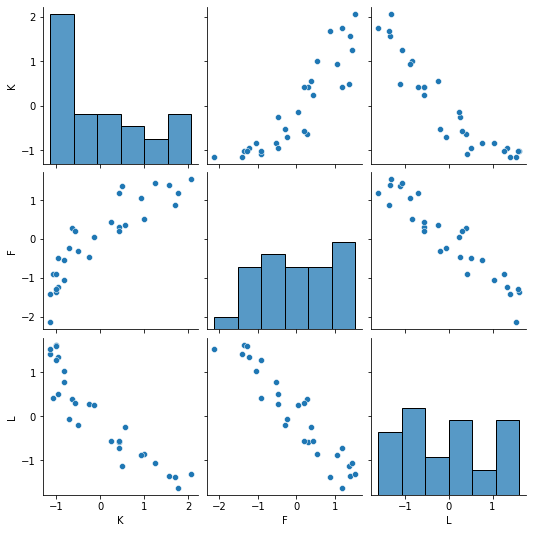

In [26]:
sns.pairplot(df_milk[['K', 'F', 'L']])

## Discussion 


The example here is similar to the one presented in Chapter 5.2 wherein the the energy content of milk was regressed against, firstly, the log of the body mass and then against the percentage of neocortex. In that example, each bivariate regression resulted in a weak association. However a combined regression of energy content of milk against both the log of the body mass and the percentage of neocortex resulted in a stronger association. 

In the current example, the opposite has been demonstrated. The bivariate regressions of the energy content of milk against, firstly, the fat content and, secondly, the lactose content individually show strong association. The combined regression shows a weak association. 

In the previous example in Section 5.2, the response $K$ is positively correlated with the neocortex percentage $N$ and negatively correlated with body mass $M$. The predictors themselves are positively correlated. In this case, in the combined regression, the predictors tend to cancel each other out and the multiple regression revealed the true nature of the association. 

In the current example, the response $K$ is positively correlated with $F$ and negatively correlated with $L$. The predictors themselves are strongly negatively correlated with one another. In this example, the fat content can be used to predict the lactose content quite accurately and vice versa.  